In [21]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


In [22]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    
    features = ["alpha", "delta", "u", "g", "r", "i", "z", "redshift"]
    X = data[features]
    
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data["class"])
    
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3)
    # Ensure approximately even distribution of classes
    min_class_count = min(np.bincount(y))
    indices = np.hstack([np.random.choice(np.where(y == i)[0], min_class_count, replace=False) for i in np.unique(y)])
    np.random.shuffle(indices)
    x_train, x_test, y_train, y_test = train_test_split(x_scaled[indices], y[indices], test_size=0.3)
    
    # Convert to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    # Return only 10% of the data
    x_train_tensor = x_train_tensor[:int(0.2 * len(x_train_tensor))]
    y_train_tensor = y_train_tensor[:int(0.2 * len(y_train_tensor))]
    x_test_tensor = x_test_tensor[:int(0.2 * len(x_test_tensor))]
    y_test_tensor = y_test_tensor[:int(0.2 * len(y_test_tensor))]
    
    return x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor

In [23]:
x_train, x_test, y_train, y_test = load_and_preprocess_data("star_classification.csv")

# Define SVM model with GridSearchCV for hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['linear', 'rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(x_train, y_train)

print(f"Best parameters: {grid.best_params_}")

y_pred = grid.predict(x_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   2.7s
[CV] END ....................C=0.1, gamma=0.1, k

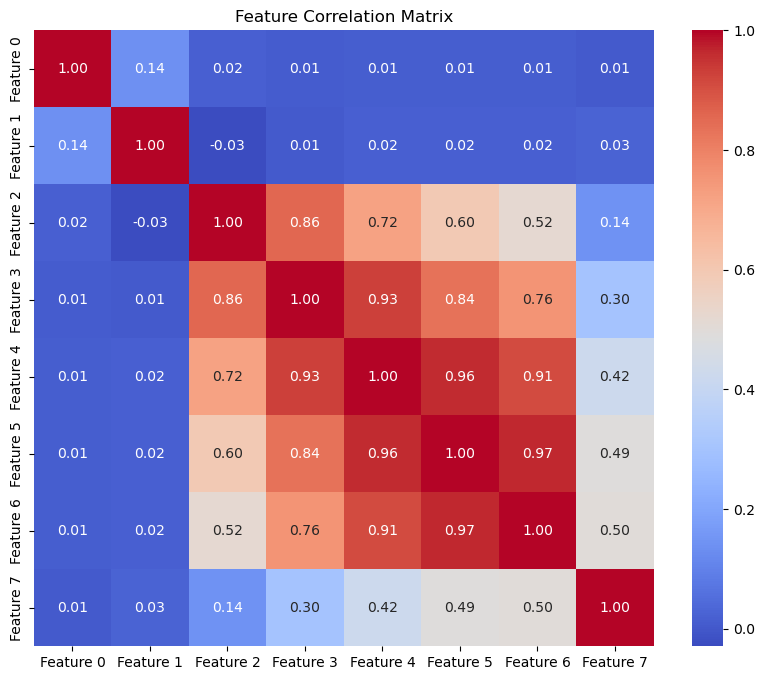

In [24]:
# Correlation heatmap for the training data
def plot_correlation_matrix(X):
    df = pd.DataFrame(X, columns=[f"Feature {i}" for i in range(X.shape[1])])
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Matrix")
    plt.show()

plot_correlation_matrix(x_train)

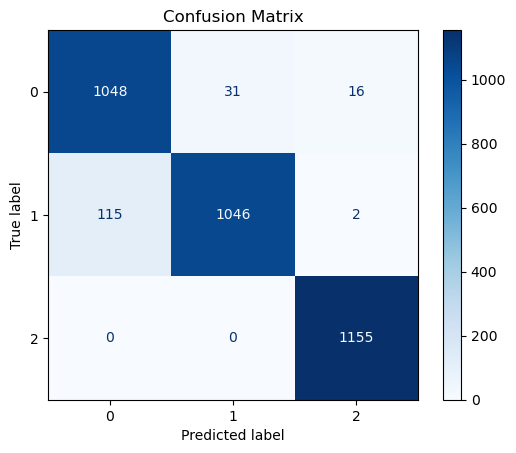

In [25]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

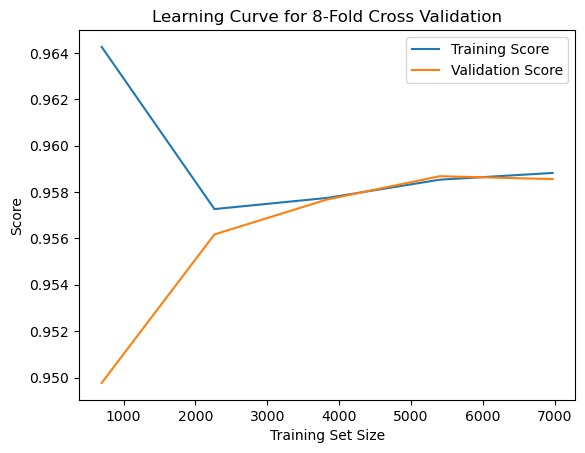

In [26]:
# Plot learning curve
def plot_learning_curve(estimator, X, y, cv=8):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label="Training Score")
    plt.plot(train_sizes, test_mean, label="Validation Score")
    # plt.fill_between(train_sizes, train_mean, test_mean, alpha=0.1)
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Learning Curve for 8-Fold Cross Validation")
    plt.show()

plot_learning_curve(grid.best_estimator_, x_train, y_train)

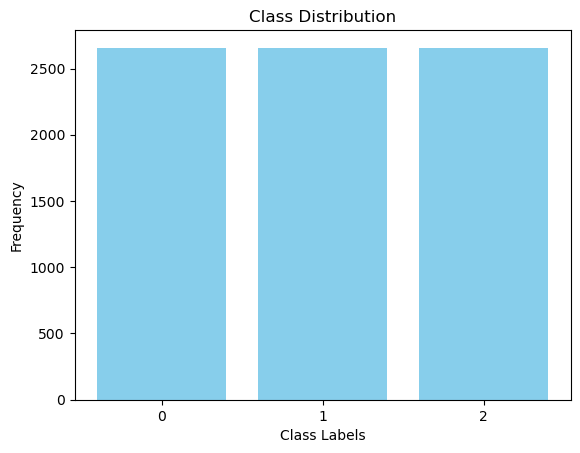

In [27]:
# Plot class distribution
def plot_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(unique, counts, color="skyblue")
    plt.xlabel("Class Labels")
    plt.ylabel("Frequency")
    plt.title("Class Distribution")
    plt.xticks(unique)
    plt.show()

plot_class_distribution(y_train)

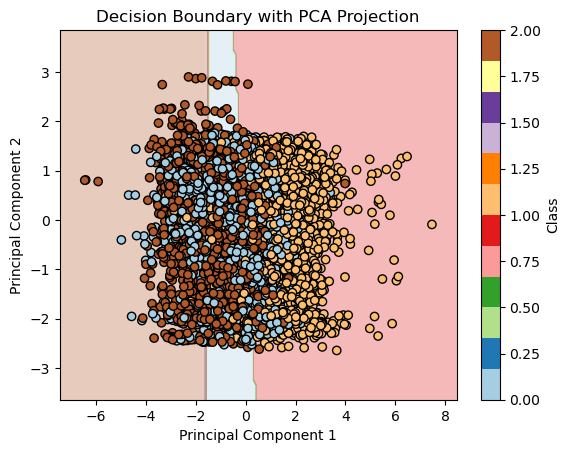

In [ ]:
def plot_pca(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA Projection")
    plt.colorbar(label="Class")
    plt.show()

def plot_decision_boundary(X, y, model):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("Decision Boundary with PCA Projection")
    plt.colorbar(label="Class")
    plt.show()

plot_decision_boundary(x_train, y_train, grid.best_estimator_)

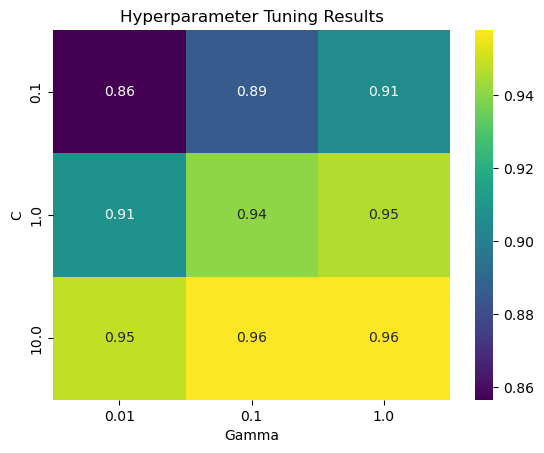

In [29]:
# Pivot table for heatmap
def plot_hyperparameter_heatmap(results):
    pivot_table = results.pivot_table(index="param_C", columns="param_gamma", values="mean_test_score")
    sns.heatmap(pivot_table, annot=True, cmap="viridis")
    plt.title("Hyperparameter Tuning Results")
    plt.xlabel("Gamma")
    plt.ylabel("C")
    plt.show()
    
results = pd.DataFrame(grid.cv_results_)
plot_hyperparameter_heatmap(results)

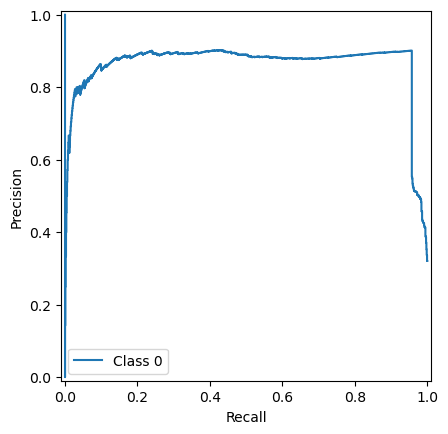

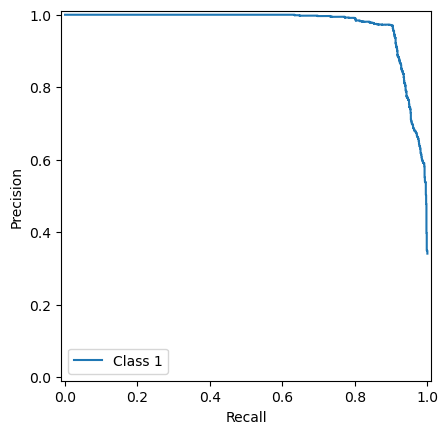

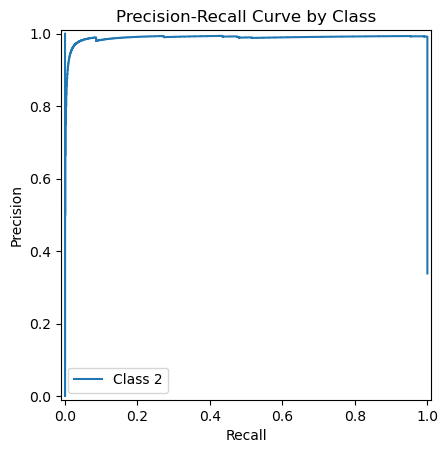

In [30]:
# Plot precision-recall curves
def plot_precision_recall(y_true, y_score, classes):
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_true == class_label, y_score[:, i])
        display = PrecisionRecallDisplay(precision=precision, recall=recall)
        display.plot(name=f"Class {class_label}")
    plt.title("Precision-Recall Curve by Class")
    plt.show()

# Compute decision function scores for test set
y_score = grid.decision_function(x_test)
plot_precision_recall(y_test, y_score, classes=[0, 1, 2])